<h1 align="center">Machine Learning - 25737</h1>
<h4 align="center">Dr. Amini</h4>
<h4 align="center">Sharif University of Technology, Spring 2023</h4>
<h4 align="center">Project phase 2</h4>
<h4 align="center">Amir Hossein Yari , Amir Hossein Moraveji</h4>
<h5 align="center">99102507 , 99104232</h5>





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import MNIST
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import zipfile
import cv2
from io import BytesIO
from skimage.metrics import mean_squared_error

## <font color='yellow'> Simulation Question 1 </font>

In [2]:
# Loading the dataset
train_set = MNIST(root='.', train=True, download=True)

data_all = train_set.data.numpy()
targets_all = train_set.targets.numpy()

print('all data : ',type(data_all) , data_all.shape)
print('all targets : ',type(targets_all) , targets_all.shape)

# choose N samples with n=N/10 samples for each digit
N = 100
n = int(N/10)
data = np.zeros((N,28,28))
targets = np.zeros((N,))
for i in  range(10):
    idx = (targets_all==i)
    data[n*i:n*(i+1),:,:] = data_all[idx][:n,:,:]
    targets[n*i:n*(i+1)] = targets_all[idx][:n]

print('chosen data : ',type(data) , data.shape)
print('chosen targets : ',type(targets) , targets.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 103590437.31it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25305137.63it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25250063.52it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12019261.05it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

all data :  <class 'numpy.ndarray'> (60000, 28, 28)
all targets :  <class 'numpy.ndarray'> (60000,)
chosen data :  <class 'numpy.ndarray'> (100, 28, 28)
chosen targets :  <class 'numpy.ndarray'> (100,)


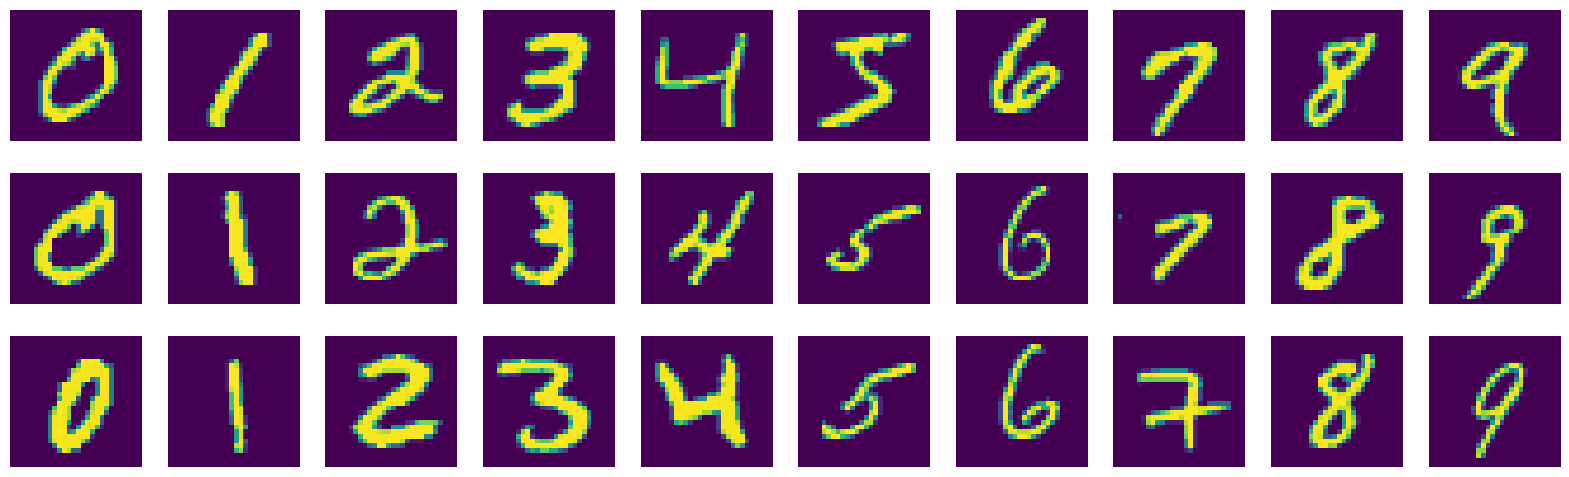

In [4]:
# take a look at some examples from the dataset
plt.figure(figsize=(20,6))
for i in  range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(data[0+i*10])
    plt.axis('off')
    plt.subplot(3,10,i+11)
    plt.imshow(data[1+i*10])
    plt.axis('off')
    plt.subplot(3,10,i+21)
    plt.imshow(data[2+i*10])
    plt.axis('off')

In [5]:
# extracting patches and vectorizing them
def extract_1(img , m):
    L = len(img)
    n = L-m+1
    n2 = n**2
    m2 = m**2
    p = np.zeros((n2,m2))
    for i in range(n):
        for j in range(n):
            p[i*n+j,:] = img[i:i+m,j:j+m].reshape((1,m2))/255
    return p
def extract(data , m):
    n = (28-m+1)**2
    N = len(data)
    patches = np.zeros((N*n,m**2))
    for i in range(N):
        patches[i*n:(i+1)*n,:] = extract_1(data[i,:,:] , m)
    return patches

## <font color='yellow'> Simulation Question 2 </font>

In [ ]:
# ----- No Need to run this box -----
# EM Algorithm ( written by us )
def mvn_prob(vector, mean, covariance):
    D = len(vector)
    vector = vector.reshape((D,1))
    mean = mean.reshape((D,1))
    diff = vector - mean
    prob = np.exp(-0.5 * diff.T @ np.linalg.inv(covariance) @ diff) / ((2 * np.pi)**(D/2) * np.linalg.det(covariance)**(1/2))
    return prob

def E_step(pi , mu , sigma , data ):
    N = len(data)
    K = len(mu)
    pi = pi.reshape((K,1))
    q = np.zeros((N,K))
    for n in range(N):
        denom = 0
        for k in range(K):
            p = mvn_prob(data[n,:], mu[k,:], sigma[k,:,:])
            denom += pi[k]*p
        for k in range(K):
            q[n,k] = pi[k]*mvn_prob(data[n,:], mu[k,:], sigma[k,:,:])/denom
    return q

def M_step(q , data ):
    N = len(data)
    D = len(data[0,:])
    K = len(q[0,:])
    pi = q.mean(axis=0)
    mu = np.zeros((K,D))
    sigma = np.zeros((K,D,D))
    for k in range(K):
        den = pi[k] if pi[k]>0 else 0.0001
        mu[k,:] = np.mean(np.diag(q[:,k]) @ data , axis=0) / den
        for n in range(N):
            d = data[n,:] - mu[k,:]
            sigma[k,:,:] += q[n,k]*(d.reshape((D,1)) @ d.reshape((1,D)))
        sigma[k,:,:] += np.diag(0.0001*np.ones(D))
        sigma[k,:,:] /= (den*N)
    return pi , mu , sigma

def EM_loop(data , step , pi , mu , sigma):
    q = E_step(pi , mu , sigma , data)
    pi_new , mu_new , sigma_new = M_step(q , data)
    step -= 1
    if step==0 :
        return pi_new , mu_new , sigma_new
    else :
        return EM_loop(data , step , pi_new , mu_new , sigma_new)

def initialize(data , K):
    D = len(data[0,:])
    pi = np.ones((1,K)) / K
    M = data.max()
    m = data.min()
    mu = (np.random.rand(K,D)-0.5)*(M-m)/4 + (M+m)/2
    sigma = np.zeros((K,D,D))
    for k in range(K):
        r = np.random.rand(D)
        sigma[k,:,:] = np.diag(r)
    return pi , mu , sigma

def EM_algorithm(data , K , step):
    pi , mu , sigma = initialize(data , K )
    pi , mu , sigma = EM_loop(data , step , pi , mu , sigma)
    return pi , mu , sigma

In [6]:
# python GMM
def train(input_data , K):
    gm = GaussianMixture(n_components=K, init_params="random_from_data").fit(input_data)
    return gm

## <font color='yellow'> Simulation Question 3 </font>

In [ ]:
#def prob(data , mu , sigma):
#    N = len(data)
#    D = len(mu)
#    mu = mu.reshape((D,))
#    pr = multivariate_normal.logpdf(data , mean=mu , cov=sigma)
#    return pr.sum()

def denoise(img , W , sigma2_y , gm ): # sigma2_y = (sigma(y))**2
    D = len(W)
    m = int(np.sqrt(D))
    patches = extract_1(img , m)
    N = len(patches)
    l = 28-m+1
    p = gm.predict_proba(patches)
    idx = np.argmax(p,axis=1)
    sigma_z = gm.covariances_
    mu_z = gm.means_
    sigma_y = np.eye(D)*sigma2_y
    denoised_img = np.zeros((28,28))
    count = np.zeros((28,28))
    for n in range(N):
        k = idx[n]
        sigma_z_inv = np.linalg.inv(sigma_z[k,:,:])
        sigma_y_k = sigma_y + W @ sigma_z[k,:,:] @ W.T
        sigma_y_inv = np.linalg.inv(sigma_y_k)
        sigma_zy = np.linalg.inv(sigma_z_inv + W.T @ sigma_y_inv @ W)
        mu_zy = sigma_zy @ (W.T @ sigma_y_inv @ patches[n,:].reshape((D,1)) + sigma_z_inv @ mu_z[k,:].reshape((D,1)))
        a = n//l
        b = n%l
        denoised_img[a:a+m , b:b+m] += mu_zy.reshape((m,m))
        count[a:a+m , b:b+m] += np.ones((m,m))
    for i in range(28):
        for j in range(28):
            denoised_img[i,j] /= count[i,j]
            denoised_img[i,j] *= 255
    return denoised_img

#    D = len(W)
#    m = int(np.sqrt(D))
#    K = len(pi)
#    l = 28-m+1
#    patches = extract_1(img , m)
#    N = len(patches)
#    denoised_patches = np.zeros((N,D))
#    denoised_img = np.zeros((28,28))
#    count = np.zeros((28,28))
#    p = np.zeros((K,))
#    sigma_y = np.eye(D)*sigma2_y
#    for n in range(N):
#        for k in range(K):
#            sigma_z_inv = np.linalg.inv(sigma_z[k,:,:])
#            sigma_y_k = sigma_y + W @ sigma_z[k,:,:] @ W.T
#            sigma_y_inv = np.linalg.inv(sigma_y_k)
#            sigma_zy = np.linalg.inv(sigma_z_inv + W.T @ sigma_y_inv @ W)
#            mu_zy = sigma_zy @ (W.T @ sigma_y_inv @ patches[n,:].reshape((D,1)) + sigma_z_inv @ mu_z[k,:].reshape((D,1)))
#            #p[k] = np.log(pi[k])+prob(data[np.arange(n,len(data),N),:] , mu_zy , sigma_zy)
#            p[k] = np.log(pi[k])+prob(data , mu_zy , sigma_zy)
#        idx = np.argmax(p)
#        a = n//l
#        b = n%l
#        denoised_img[a:a+m , b:b+m] += mu_z[idx,:].reshape((m,m))
#        count[a:a+m , b:b+m] += np.ones((m,m))
#    for i in range(28):
#        for j in range(28):
#            denoised_img[i,j] /= count[i,j]
#            denoised_img[i,j] *= 255
#    return denoised_img

## <font color='yellow'> Simulation Question 4 </font>

MNIST-m=4.zip
MNIST-m=8.zip
MNIST-m=12.zip
MNIST-m=16.zip
MNIST-m=20.zip
MNIST-m=28.zip
best m =   28
best K = 4 
best sigma = 5 


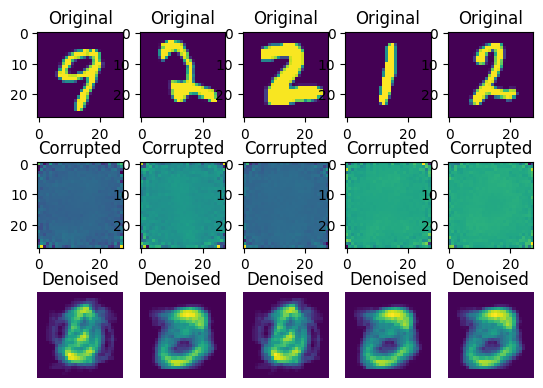

In [ ]:
def read_zip(zip_filename):
  # Opening the zip file
  with zipfile.ZipFile(zip_filename, "r") as zfile:
    # Getting the list of filenames in the zip file
    list_of_filenames = zfile.namelist()
    original = []
    corrupted = []
    W = None
    for filename in list_of_filenames:
      # Reading the file data as bytes
      data = zfile.read(filename)
      # Checking if the file is an image or a numpy file
      if filename.endswith(".png"):
        # Decoding the image data using cv2.imdecode
        img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
        # Checking if the image belongs to original or corrupted folder
        if "original" in filename:
          original.append(img)
        elif "corrupted" in filename:
          corrupted.append(img)
      elif filename.endswith(".npy"):
        W = np.load(BytesIO(data))
    return original, corrupted, W


# Initialize m, K, sigma
m_arr = [4, 8, 12, 16, 20, 28]
K_arr = [4, 8, 12, 16, 32]
sigma_arr = [5, 10, 20, 30, 50]


# Find best m
cmp_image = np.zeros(len(m_arr))
i1 = -1
K = 8
sigma = 10
for i in(m_arr):
    i1 += 1
    # Read zip and initialize original and corrupted images and W.npy
    original, corrupted, W = read_zip("MNIST-m=%s.zip" %(i))
    example_image_org = original[10][:,:,0]
    example_image_cor = corrupted[10][:,:,0]
    # training
    patches = extract(data , i)
    gm = train(patches , K)
    # denoise
    denoised_img = denoise(example_image_cor , W , sigma , gm )
    cmp_image[i1] = mean_squared_error(example_image_org, denoised_img)
m_best = np.unravel_index(cmp_image.argmin(), cmp_image.shape)
print("best m =  ", m_arr[m_best[0]])

# Find best K
cmp_image = np.zeros([len(K_arr)])
i1 = -1
m = m_arr[m_best[0]]
# Read zip and initialize original and corrupted images and W.npy
original, corrupted, W = read_zip("MNIST-m=%s.zip" %(m))
example_image_org = original[10][:,:,0]
example_image_cor = corrupted[10][:,:,0]
sigma = 10
patches = extract(data , m)
for i in(K_arr):
    i1 += 1
    # training
    gm = train(patches , i)
    # denoise
    denoised_img = denoise(example_image_cor , W , sigma , gm )
    cmp_image[i1] = mean_squared_error(example_image_org, denoised_img)
K_best = np.unravel_index(cmp_image.argmin(), cmp_image.shape)
print("best K = %s " % (K_arr[K_best[0]]))

# Find best sigma
cmp_image = np.zeros([len(sigma_arr)])
i1 = -1
K = K_arr[K_best[0]]
# training
patches = extract(data , m)
gm = train(patches , K)
for i in(sigma_arr):
    i1 += 1
    # denoise
    denoised_img = denoise(example_image_cor , W , i , gm )
    cmp_image[i1] = mean_squared_error(example_image_org, denoised_img)
sigma_best = np.unravel_index(cmp_image.argmin(), cmp_image.shape)
print("best sigma = %s " % (sigma_arr[sigma_best[0]]))

# denoise some corrupted images with best m,K,sigma and plot it
sigma = sigma_arr[sigma_best[0]]
# training
pi = gm.weights_
mu_z = gm.means_
sigma_z = gm.covariances_

# plotting
plt.figure()
i = 0
for img in(corrupted[:5]):
  # denoise image
  denoised_img = denoise(img[:,:,0] , W , sigma , gm)
  plt.subplot(3,5,i+1)
  plt.imshow(original[i][:,:,0])
  plt.title("Original")
  plt.subplot(3,5,i+6)
  plt.imshow(corrupted[i][:,:,0])
  plt.title("Corrupted")
  plt.subplot(3,5,i+11)
  plt.imshow(denoised_img)
  plt.title("Denoised")
  plt.axis("off")
  i += 1

4
4
12
32
16
4
12
32
28
4
12
32


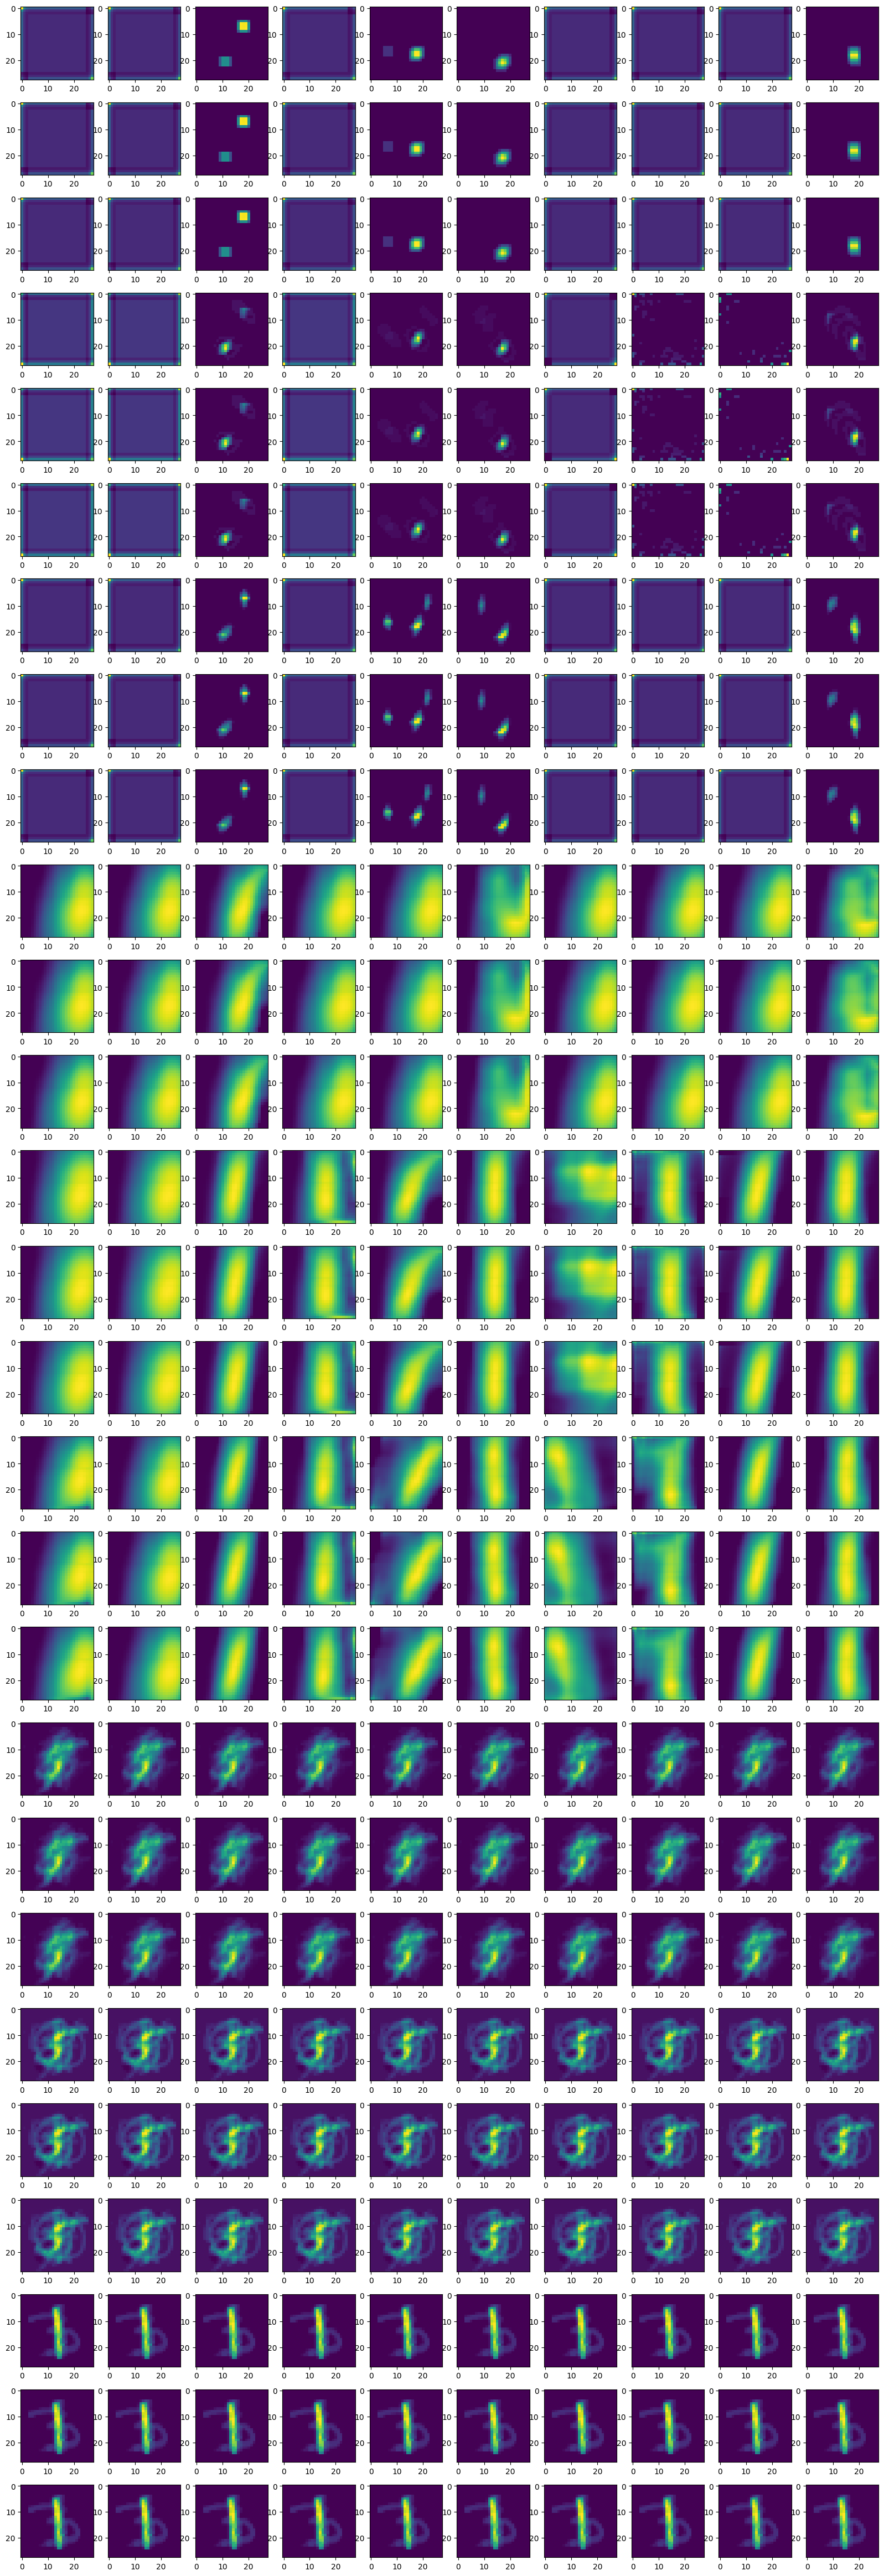

In [ ]:
# ---> ---> ---> DO NOT RUN THIS SECTION <--- <--- <---
# Just See the results.
f = ['7','1','14','2','58','45','6','9','5','10']
m_arr = [4, 16, 28]
K_arr = [4, 12, 32]
sigma_arr = [5, 20, 50]

org_img = 10*[[]]
cor_img = len(m_arr)*[org_img.copy()]
den_img = {}
W = 10*[[]]
for i in range(10):
    org_img[i] = plt.imread('dataset/original/'+f[i]+'.png')
for j in range(len(m_arr)):
    m = m_arr[j]
    W[j] = np.load('dataset/m='+str(m)+'/W.npy')
    for i in range(10):
        cor_img[j][i] = plt.imread('dataset/m='+str(m)+'/'+f[i]+'.png')

for j in range(len(m_arr)):
    m = m_arr[j]
    print(m)
    patches = extract(data,m)
    for k in (K_arr):
        print(k)
        gm = train(patches,k)
        for s in (sigma_arr):
            for i in range(10):
                den_img['m='+str(m)+',K='+str(k)+',s='+str(s)+',i='+str(i)] = denoise(cor_img[j][i],W[j],sigma,gm)

plt.figure(figsize=(20,60))
j=1
for m in (m_arr):
    for k in (K_arr):
        for s in (sigma_arr):
            for i in range(10):
                plt.subplot(27,10,j)
                plt.imshow(den_img['m='+str(m)+',K='+str(k)+',s='+str(s)+',i='+str(i)])
                j +=1


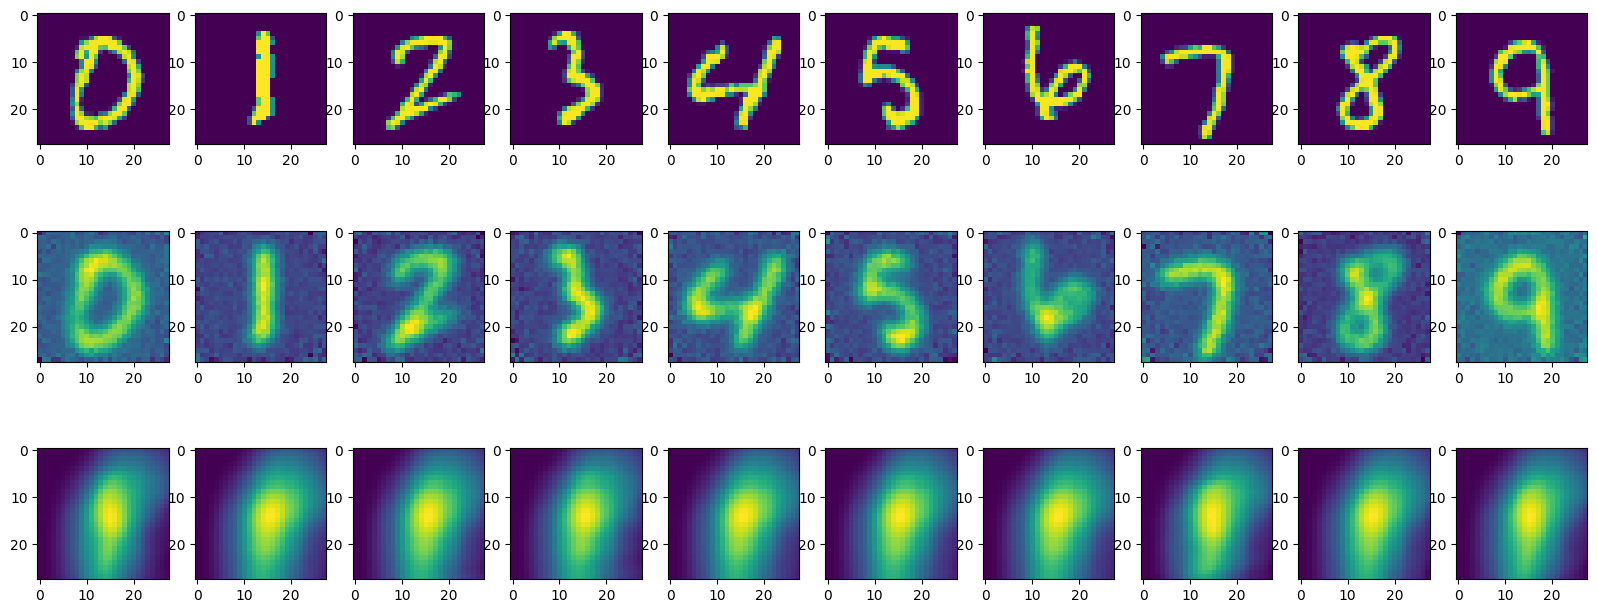

In [ ]:
f = ['7','1','14','2','58','45','6','9','5','10']
m = 20
k = 10
s = 1
patches = extract(data,m)
gm = train(patches,k)
plt.figure(figsize=(20,8))
for i in range(10):
    org_img = plt.imread('dataset/original/'+f[i]+'.png')
    cor_img = plt.imread('dataset/m=8/'+f[i]+'.png')
    W = np.load('dataset/m='+str(m)+'/W.npy')
    den_img = denoise(cor_img,W,s,gm)
    plt.subplot(3,10,i+1)
    plt.imshow(org_img)
    plt.subplot(3,10,i+11)
    plt.imshow(cor_img)
    plt.subplot(3,10,i+21)
    plt.imshow(den_img)